# TAREA 2

### Aplicar los conceptos de KNN, regresión y GBM en datos reales.

In [2]:
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
import seaborn as sns

# 1 Regresión

Realizar la exploración de los datos correlación, scatter plots, boxplots e
histogramas:


###  1.1. ¿Qué variables son importantes para predecir el valor?

In [5]:
dfr = pd.read_csv("data/training_pruebas.csv", low_memory=False)
irrelevantes = [
    "ESTU_TIPODOCUMENTO", "ESTU_NACIONALIDAD","PERIODO","ESTU_CONSECUTIVO","ESTU_ESTUDIANTE","ESTU_PAIS_RESIDE",
    "ESTU_DEPTO_RESIDE","ESTU_MCPIO_RESIDE","ESTU_ESTADOCIVIL","ESTU_TIPODOCUMENTOSB11","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE",
    "FAMI_TRABAJOLABORPADRE","FAMI_TRABAJOLABORMADRE","FAMI_CUANTOSCOMPARTEBAÑO",
    "ESTU_PRESENTACIONCASA","ESTU_PRESENTACIONSABADO","INST_NOMBRE_INSTITUCION","ESTU_PRGM_ACADEMICO","GRUPOREFERENCIA",
    "ESTU_PRGM_MUNICIPIO","ESTU_PRGM_DEPARTAMENTO","ESTU_NUCLEO_PREGRADO","ESTU_NUCLEO_PREGRADO_1",
    "ESTU_INST_MUNICIPIO","ESTU_INST_DEPARTAMENTO","INST_CARACTER_ACADEMICO","INST_ORIGEN","ESTU_MCPIO_PRESENTACION",
    "ESTU_DEPTO_PRESENTACION","ESTU_ESTADOINVESTIGACION", "ESTU_COD_RESIDE_DEPTO", "ESTU_COD_RESIDE_MCPIO",
    "ESTU_SNIES_PRGMACADEMICO","ESTU_PRGM_CODMUNICIPIO","ESTU_INST_CODMUNICIPIO","ESTU_COD_MCPIO_PRESENTACION","ESTU_COD_DEPTO_PRESENTACION"
]

df = dfr.drop(columns = irrelevantes)

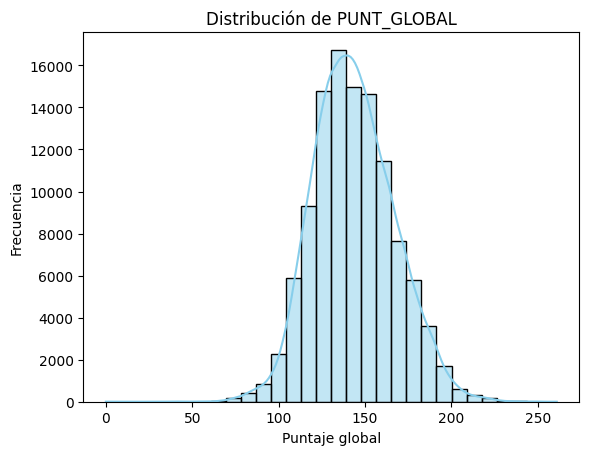

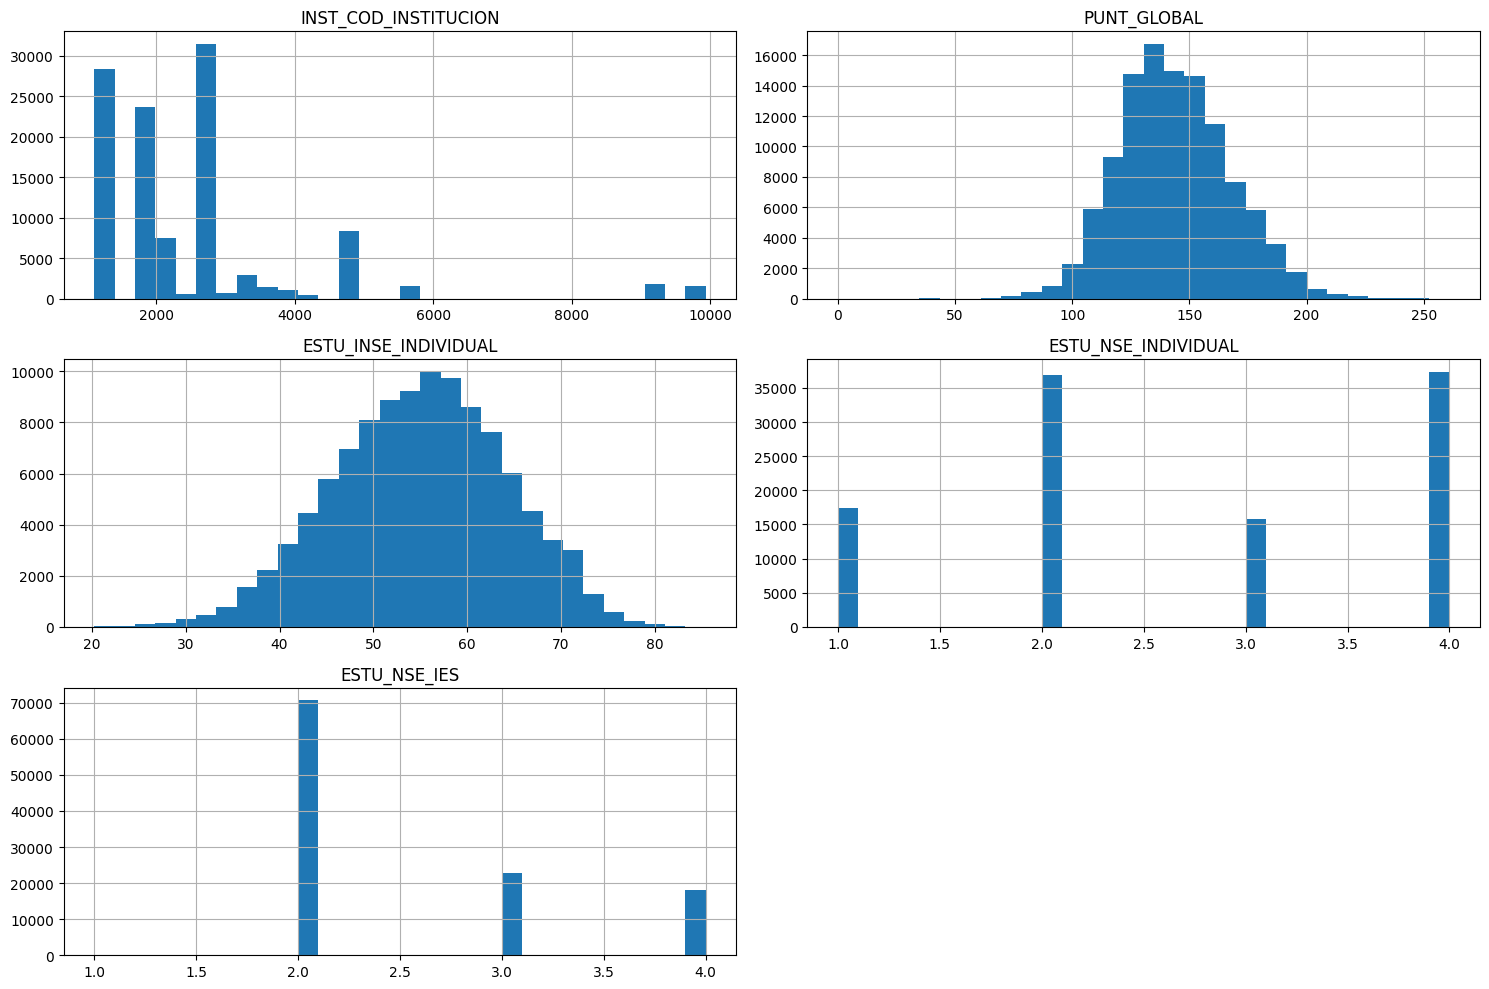

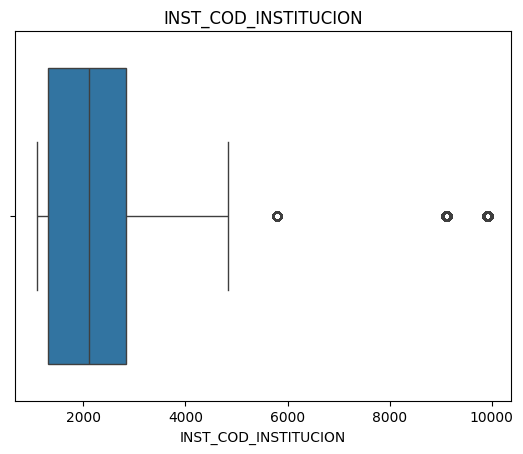

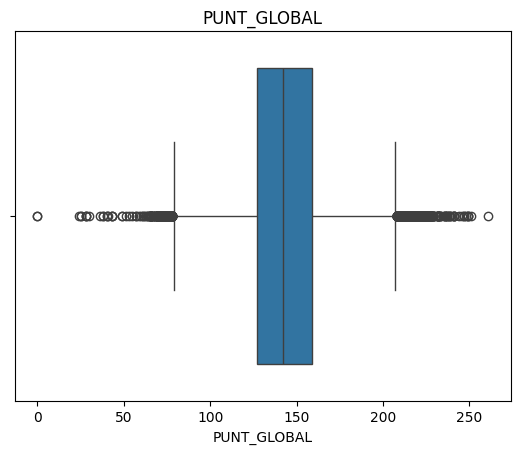

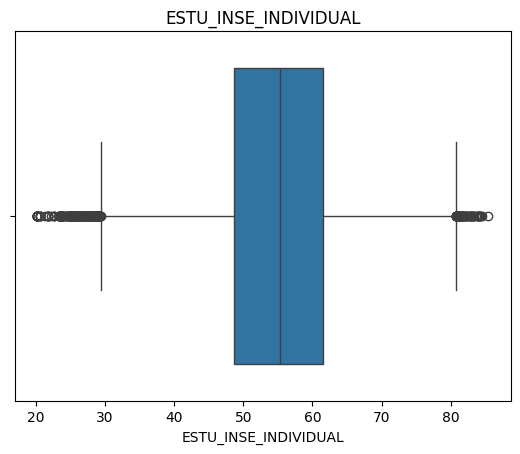

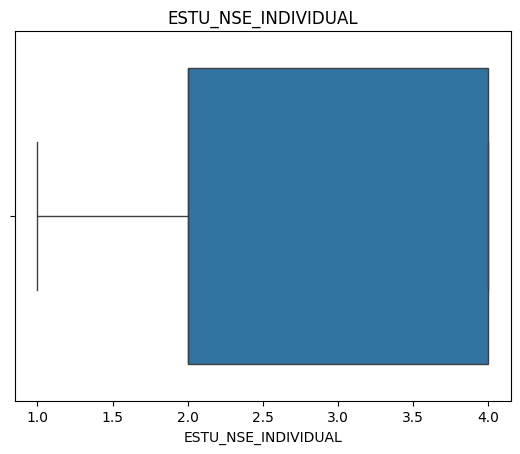

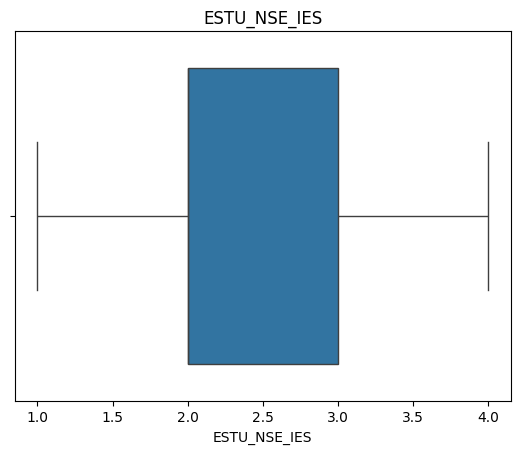

In [9]:
sns.histplot(df['PUNT_GLOBAL'], bins=30, kde=True, color='skyblue')
plt.title("Distribución de PUNT_GLOBAL")
plt.xlabel("Puntaje global")
plt.ylabel("Frecuencia")
plt.show()

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

### 1.2. Existen nulos?, ¿cómo se deben imputar?

In [10]:
ColumnasC = ["ESTU_INSE_INDIVIDUAL","ESTU_NSE_INDIVIDUAL", "ESTU_NSE_IES"]
ColumnasCat = [col for col in df.columns if (col not in ColumnasC) and (col != "PUNT_GLOBAL")]

def rellenarNulos(data):

    dataN = data.copy()
    mean = dataN[ColumnasC].mean()
    mode = dataN[ColumnasCat].mode()

    for col in dataN[ColumnasC]:
        for i, val in enumerate(dataN[col]):
            if math.isnan(val):
                dataN.loc[i, col] = mean[col]

    dataN[ColumnasCat] = dataN[ColumnasCat].apply(lambda x: x.fillna(x.value_counts().index[0]))

    return dataN

df = rellenarNulos(df)

for i, val in enumerate(df["PUNT_GLOBAL"]):
    if math.isnan(val):
        df.loc[i, col] = df["PUNT_GLOBAL"].mean()


### 1.3. Crear dummy variables para incluirlas en la correlación

In [11]:
def transformarD(data):

    data["ESTU_FECHANACIMIENTO"] = pd.to_datetime(data["ESTU_FECHANACIMIENTO"], format="mixed", dayfirst=True, errors='coerce')
    today = pd.to_datetime('today', format="%d/%m/%Y")
    data["ESTU_FECHANACIMIENTO"] = data["ESTU_FECHANACIMIENTO"].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
    age_mean = data["ESTU_FECHANACIMIENTO"].mean()

    for i, val in enumerate(data["ESTU_FECHANACIMIENTO"]):
        if str(val) == 'nan':
            data.loc[i, "ESTU_FECHANACIMIENTO"] = age_mean

    binary_mappings = {
        "ESTU_GENERO": {'F': 1, 'M': 0},
        "ESTU_EXTERIOR": {'SI': 1, 'NO': 0},
        "ESTU_AREARESIDE": {'Cabecera Municipal': 1, 'Area Rural': 0},
        "ESTU_PAGOMATRICULABECA": {'Si': 1, 'No': 0},
        "ESTU_PAGOMATRICULACREDITO": {'Si': 1, 'No': 0},
        "ESTU_PAGOMATRICULAPADRES": {'Si': 1, 'No': 0},
        "ESTU_PAGOMATRICULAPROPIO": {'Si': 1, 'No': 0},
        "ESTU_SIMULACROTIPOICFES": {'Si': 1, 'No': 0},
        "ESTU_ACTIVIDADREFUERZOAREAS": {'Si': 1, 'No': 0},
        "ESTU_ACTIVIDADREFUERZOGENERIC": {'Si': 1, 'No': 0},
        "FAMI_TIENEINTERNET": {'Si': 1, 'No': 0},
        "FAMI_TIENECOMPUTADOR": {'Si': 1, 'No': 0},
        "FAMI_TIENELAVADORA": {'Si': 1, 'No': 0},
        "FAMI_TIENEHORNOMICROOGAS": {'Si': 1, 'No': 0},
        "FAMI_TIENESERVICIOTV": {'Si': 1, 'No': 0},
        "FAMI_TIENEAUTOMOVIL": {'Si': 1, 'No': 0},
        "FAMI_TIENEMOTOCICLETA": {'Si': 1, 'No': 0},
        "FAMI_TIENECONSOLAVIDEOJUEGOS": {'Si': 1, 'No': 0},
        "ESTU_METODO_PRGM": {'DISTANCIA VITUAL': 1, 'PRESENCIAL': 0},
        "ESTU_PRIVADO_LIBERTAD": {'S': 1, 'N': 0}
    }

    for col, mapping in binary_mappings.items():
        if col in data.columns:
            data[col] = data[col].map(mapping).fillna(data[col])

    return data

transformarD(df)
print("Nulos: ", np.nonzero(pd.isnull(df)))
df

Nulos:  (array([], dtype=int64), array([], dtype=int64))


,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_TITULOOBTENIDOBACHILLER,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,...,ESTU_PAGOMATRICULA,ESTU_VLRULTIMOSEMESCURSADO,INST_COD_INSTITUCION,ESTU_NIVEL_PRGM_ACADEMICO,ESTU_METODO_PRGM,ESTU_PRIVADO_LIBERTAD,PUNT_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_IES
0,0,24.0,0,1,Bachiller académico,Entre 500 mil y menos de 1 millón,1,0,0,0,...,Familiares,Menos de 500 mil pesos,1202,UNIVERSITARIO,0.0,0,188,55.570156,3.000000,2
1,0,23.0,0,1,Bachiller académico,Entre 1 millón y menos de 2.5 millones,1,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,DISTANCIA,0,140,38.105883,1.000000,2
2,1,28.0,0,1,Bachiller académico,Entre 1 millón y menos de 2.5 millones,1,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,DISTANCIA,0,140,65.658631,4.000000,2
3,1,29.0,0,1,Bachiller académico,No pagó matrícula,1,0,1,0,...,Becas o Subsidios,No pago semestre,1218,UNIVERSITARIO,0.0,0,111,49.260729,2.000000,2
4,1,46.0,0,1,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,1,...,Propios,Entre 3 y 5 millones,2812,UNIVERSITARIO,1.0,0,135,55.138843,2.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,1,24.0,0,1,Bachiller técnico,No pagó matrícula,1,0,1,0,...,Familiares,Entre un millon y 3 millones de pesose,1107,UNIVERSITARIO,0.0,0,137,55.028124,2.678834,2
111426,1,24.0,0,1,Bachiller académico,Entre 4 millones y menos de 5.5 millones,1,0,1,0,...,Familiares,Entre 3 y 5 millones,1805,UNIVERSITARIO,0.0,0,161,63.619372,4.000000,3
111427,0,60.0,0,1,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,1,...,Creditos,Entre un millon y 3 millones de pesose,4702,UNIVERSITARIO,0.0,0,124,48.648902,2.000000,2
111428,1,23.0,0,1,Bachiller académico,Entre 4 millones y menos de 5.5 millones,0,1,0,0,...,Creditos,Entre 3 y 5 millones,1824,UNIVERSITARIO,0.0,0,142,52.877602,2.000000,4


In [12]:
def normalizarD(data):
    for i, col in enumerate(data.columns):
        data[col] = 0 if data[col].std() == 0 else (data[col] - data[col].mean()) / data[col].std()

df_dumm = pd.get_dummies(df)
normalizarD(df_dumm)
df_dumm

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 500 mil y un millon de pesos,ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose,ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO,ESTU_METODO_PRGM_0.0,ESTU_METODO_PRGM_1.0,ESTU_METODO_PRGM_DISTANCIA
0,-1.141938,-0.709521,-0.123835,0.37177,1.534565,-0.617858,-0.834938,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0,0.575503,-0.361215,-0.392317
1,-1.141938,-0.853080,-0.123835,0.37177,1.534565,-0.617858,-0.834938,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0,-1.737594,-0.361215,2.548937
2,0.875696,-0.135285,-0.123835,0.37177,1.534565,-0.617858,-0.834938,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0,-1.737594,-0.361215,2.548937
3,0.875696,0.008274,-0.123835,0.37177,1.534565,-0.617858,1.197683,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,2.206445,0,0.575503,-0.361215,-0.392317
4,0.875696,2.448775,-0.123835,0.37177,-0.651645,-0.617858,-0.834938,1.060439,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0,-1.737594,2.768413,-0.392317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,0.875696,-0.709521,-0.123835,0.37177,1.534565,-0.617858,1.197683,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,1.419545,-0.276743,-0.387261,-0.453214,0,0.575503,-0.361215,-0.392317
111426,0.875696,-0.709521,-0.123835,0.37177,1.534565,-0.617858,1.197683,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0,0.575503,-0.361215,-0.392317
111427,-1.141938,4.458600,-0.123835,0.37177,-0.651645,-0.617858,-0.834938,1.060439,0.075645,0.098651,...,-0.273497,-0.239647,1.419545,-0.276743,-0.387261,-0.453214,0,0.575503,-0.361215,-0.392317
111428,0.875696,-0.853080,-0.123835,0.37177,-0.651645,1.618480,-0.834938,-0.942998,0.075645,0.098651,...,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0,0.575503,-0.361215,-0.392317


### 1.4. Crear una correlación, que variables tienen un efecto positivo en el puntaje y cuales un efecto negativo.

In [13]:
correlacion  = df_dumm.corr(numeric_only=True)
correlacionO = correlacion ["PUNT_GLOBAL"].sort_values(ascending=False)
print(correlacionO)

PUNT_GLOBAL                                                          1.000000
ESTU_NSE_IES                                                         0.262818
ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones                     0.244534
ESTU_INSE_INDIVIDUAL                                                 0.238292
ESTU_METODO_PRGM_0.0                                                 0.226862
                                                                       ...   
ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose   -0.185439
ESTU_METODO_PRGM_DISTANCIA                                          -0.187069
INST_COD_INSTITUCION                                                -0.205356
ESTU_FECHANACIMIENTO                                                -0.252624
ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO                                   NaN
Name: PUNT_GLOBAL, Length: 111, dtype: float64


## 2 Divida los datos en training y testing

In [14]:
x, y = df_dumm[[col for col in df_dumm.columns if col != "PUNT_GLOBAL"]], df["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=123)

###  2.1. Aplique las transformaciones más importantes a los datos. (Hint calcular la edad basada en la fecha de nacimiento, agrupar variables categóricas con mucha cardinalidad en grupos).
mirar el 1.3

### 2.2. Entrenar un modelos de regresión

In [15]:
regresion = LinearRegression()
regresion.fit(xr, yr)

LinearRegression()

### 2.3 ¿Cuál es el mejor R squared? Cuál es el MAPE y el MSE

In [16]:
predictorR = regresion.predict(xr)

def r2_(true, pred):
    SSR, SST = sum((true-pred)**2), sum((true-np.mean(true))**2)
    R2 = 1 - (float(SSR))/SST
    return R2

def mse(true, pred):
    return (1/len(true))*sum((true-pred)**2)

def mape(true, pred):
    return (100/len(true)*sum(abs(pred-true)/true))

print("Training")
print("R²   ", r2_(yr, predictorR))
print("MAPE ", mape(yr, predictorR))
print("MSE  ", mse(yr, predictorR))

Training
R²    0.2645280814644809
MAPE  inf
MSE   404.7165938556982


### 3 Remueva las variables que nos son relevantes

ver al inicio los "irrelevantes"

### 4 Utilizando los datos de test medir el MAPE y el MSE de test. Qué tan diferentes son las métricas de training. (El menor error del grupo tiene un +1)

In [17]:
predictorS = regresion.predict(xs)

print("Test:")
print("R²   ", r2_(ys, predictorS))
print("MAPE ", mape(ys, predictorS))
print("MSE  ", mse(ys, predictorS))

Test:
R²    0.2628687480428129
MAPE  11.667796533162148
MSE   405.34456408637124


### 5 Describa en palabras que dice el modelo cuales son los principales hallazgos.

kaggle regresion

In [18]:
dftr = pd.read_csv("data/test_pruebas.csv", low_memory=False)
dft = dftr.drop(columns=irrelevantes)
dft = rellenarNulos(dft)
transformarD(dft)
dft_dumm = pd.get_dummies(dft)
normalizarD(dft_dumm)
dft_dumm

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 500 mil y un millon de pesos,ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose,ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO,ESTU_METODO_PRGM_0.0,ESTU_METODO_PRGM_1.0,ESTU_METODO_PRGM_DISTANCIA
0,0.873960,3.004117,-0.122216,0.362459,-0.653165,1.643914,-0.833058,-0.946695,0.075763,0.09706,...,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0,-1.729784,-0.364358,2.550019
1,-1.144175,-0.425419,-0.122216,0.362459,1.530951,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,3.712968,-0.245202,-0.701277,-0.275324,-0.391896,-0.454123,0,0.578086,-0.364358,-0.392140
2,0.873960,-0.282522,-0.122216,0.362459,-0.653165,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.269317,-0.245202,-0.701277,-0.275324,-0.391896,2.201967,0,0.578086,-0.364358,-0.392140
3,0.873960,0.289067,-0.122216,0.362459,-0.653165,-0.608282,1.200354,-0.946695,0.075763,0.09706,...,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0,0.578086,-0.364358,-0.392140
4,0.873960,0.289067,8.181928,0.362459,-0.653165,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0,-1.729784,2.744457,-0.392140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27853,0.873960,0.574862,-0.122216,0.362459,-0.653165,1.643914,-0.833058,1.056269,0.075763,0.09706,...,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0,-1.729784,2.744457,-0.392140
27854,-1.144175,-0.711214,-0.122216,0.362459,-0.653165,1.643914,1.200354,-0.946695,0.075763,0.09706,...,-0.269317,-0.245202,-0.701277,-0.275324,-0.391896,-0.454123,0,0.578086,-0.364358,-0.392140
27855,0.873960,3.432809,-0.122216,0.362459,1.530951,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.269317,-0.245202,-0.701277,-0.275324,2.551605,-0.454123,0,-1.729784,2.744457,-0.392140
27856,0.873960,-0.139625,-0.122216,0.362459,-0.653165,-0.608282,1.200354,1.056269,0.075763,0.09706,...,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0,-1.729784,-0.364358,2.550019


In [19]:
dftPred = regresion.predict(dft_dumm)
sal = pd.DataFrame(dftPred, columns=["GLOBAL_SCORE"])

with open("Regression.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(sal["GLOBAL_SCORE"])):
        writer.writerow([dftr["ESTU_CONSECUTIVO"][i],val])

sal

,GLOBAL_SCORE
0,119.801928
1,155.651116
2,151.541352
3,135.256692
4,160.033524
...,...
27853,135.546714
27854,153.415578
27855,130.961565
27856,143.328100


# 2 Crear un modelo de KNN

### 1 Hacer pruebas con 5, 10, 20 y 30 vecinos. Seleccione el numero de vecinos basado en el error de test MSE.

In [24]:
vecinos = [5,10,20,30]

for s in vecinos:
    knn = KNeighborsRegressor(n_neighbors=s)
    knn.fit(xr, yr)
    predictorR = knn.predict(xr)
    predictorS = knn.predict(xs)
    print(f"{s} vecinos")
    print("MSE train", mse(yr, predictorR))
    print("MAPE train", mape(yr, predictorR))
    print("MSE test", mse(ys, predictorS))
    print("MAPE test", mape(ys, predictorS))


5 vecinos
MSE train 0.06843982769450338
MAPE train nan
MSE test 0.10385174549043782
MAPE test nan
10 vecinos
MSE train 0.07679260522304276
MAPE train nan
MSE test 0.09458090280893314
MAPE test nan
20 vecinos
MSE train 0.08115952840347454
MAPE train nan
MSE test 0.0904995288522009
MAPE test nan
30 vecinos
MSE train 0.08292704936831229
MAPE train nan
MSE test 0.08936098397599812
MAPE test nan


In [25]:
dftPred = knn.predict(dft_dumm)
sal = pd.DataFrame(dftPred, columns=["GLOBAL_SCORE"])
with open("KNN.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(sal["GLOBAL_SCORE"])):
        writer.writerow([dftr["ESTU_CONSECUTIVO"][i],val])

sal

,GLOBAL_SCORE
0,0.000000
1,0.133333
2,0.266667
3,0.066667
4,0.133333
...,...
27853,0.066667
27854,0.000000
27855,0.033333
27856,0.000000


### 2 Describa cual es mejor modelo entre la regresión o el knn.

# 3 Crear un modelo de GBM

In [26]:
x, y = df_dumm[[col for col in df_dumm.columns if col != "PUNT_GLOBAL"]], df["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

gbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)
gbm.fit(xr, yr)

predictorR = gbm.predict(xr)
predictorS = gbm.predict(xs)

print("MSE train", mse(yr, predictorR))
print("MAPE train", mape(yr, predictorR))
print("MSE test", mse(ys, predictorS))
print("MAPE test", mape(ys, predictorS))

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [27]:
dftPred = gbm.predict(dft_dumm)
sal = pd.DataFrame(dftPred, columns=["GLOBAL_SCORE"])

with open("GBM.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(sal["GLOBAL_SCORE"])):
        writer.writerow([dftr["ESTU_CONSECUTIVO"][i],val])

sal

,GLOBAL_SCORE
0,124
1,132
2,124
3,124
4,124
...,...
27853,124
27854,124
27855,124
27856,124


# 4 Crear un modelo de regresión logística

In [20]:
x, y = df_dumm[[col for col in df_dumm.columns if col != "PUNT_GLOBAL"]], (df["PUNT_GLOBAL"] > 172).astype(int)

In [21]:
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

lgr = LogisticRegression()
lgr.fit(xr, yr)

predictorR = lgr.predict(xr)
predictorS = lgr.predict(xs)

print("Regresion logitisca")
print("MSE train:", mse(predictorR, yr))
print("MSE test:", mse(predictorS, ys))
importance = pd.DataFrame({'Variable': dft_dumm.columns, 'Coeficiente': lgr.coef_[0]}).sort_values(ascending=False, by=["Coeficiente"]).iloc[1:]
importance

Regresion logitisca
MSE train: 0.10910437045678902
MSE test: 0.11172933680337432


,Variable,Coeficiente
21,ESTU_INSE_INDIVIDUAL,0.193856
3,ESTU_AREARESIDE,0.180011
14,FAMI_TIENEHORNOMICROOGAS,0.165598
12,FAMI_TIENECOMPUTADOR,0.163017
2,ESTU_EXTERIOR,0.147731
...,...,...
17,FAMI_TIENEMOTOCICLETA,-0.203815
83,FAMI_ESTRATOVIVIENDA_Estrato 1,-0.211250
109,ESTU_METODO_PRGM_DISTANCIA,-0.223508
1,ESTU_FECHANACIMIENTO,-0.403597


In [22]:
confusionr = pd.DataFrame(metrics.confusion_matrix(yr, predictorR))
print("Matriz de confusion train")
confusionr
precisionr, accuarir, recallr = precision_score(yr, predictorR), accuracy_score(yr, predictorR), recall_score(yr, predictorR)
print("PRECISION:",precisionr)
print("ACCURACY:",accuarir)
print("RECALL:", recallr)

Matriz de confusion train
PRECISION: 0.615103127079175
ACCURACY: 0.890895629543211
RECALL: 0.17748128239585334


In [23]:
confusions = pd.DataFrame(metrics.confusion_matrix(ys, predictorS))
print("Matriz de confusion test")
confusions
precisions, accuaris, recalls = precision_score(ys, predictorS), accuracy_score(ys, predictorS), recall_score(ys, predictorS)
print("PRECISION:",precisions)
print("ACCURACY:",accuaris)
print("RECALL:", recalls)

Matriz de confusion test
PRECISION: 0.6115485564304461
ACCURACY: 0.8882706631966257
RECALL: 0.17518796992481203
